# Aims
1. Change the equations to be dimensionless.

1. Generation of Gaussian random velocity field.

    $$
    \~{u}_i = \delta_{i1} - \sigma \sqrt{\frac{2}{N}} \sum_{j=1}^{N} p_i(\~{\mathbf{k}}^{(j)}) \cos(\~{\mathbf{k}}^{(j)} \cdot \~{\mathbf{x}} + \phi^{(j)})
    $$,

    where $\~{u}_i := \frac{u_i}{\bar{u}}$ is dimensionless velocity field, $\bar{u}$ is the mean magnitude of velocity field $\mathbf{u}$, $p_i(\~{\mathbf{k}}) := \delta_{i1} - k_i k_1 / k^2$, $\~{k}_i:=k_i l \sim N(0,1)$, $l$ is correlation length, $\sigma^2$ is variance, $\phi \sim \text{Uniform}(0, 2\pi)$, $N$ is the number of modes.

1. Random walk particle tracking with Runge-Kutta method.
    
    $$
    \~{\mathbf{x}}^{(i)} = \~{\mathbf{x}}^{(0)} + \sum_{j=1}^{i} (\alpha_{ij} \~{\mathbf{\mu}}^{(j)} + \beta_{ij} \~{\mathbf{\epsilon}}^{(j)}),\\
    \~{\mathbf{X}}(\tau + \Delta \tau) = \~{\mathbf{x}}^{(N)}, \~{\mathbf{x}}^{(0)} = \~{\mathbf{X}}(\tau)\\
    \~{\mathbf{\mu}}^{(j)} = \~{\mathbf{u}}(\~{\mathbf{x}}^{(j-1)}) \Delta \tau,\\
    \~{\mathbf{\epsilon}}^{(j)} = \sigma \sqrt{2 \~{D}\Delta \tau} \; \mathbf{\eta}^{(j)}, \mathbf{\eta}^{(j)} \sim N(0,1).
    $$

    where $\tau := \frac{\bar{u}}{l}t$ is dimensionless time, $\~{D} := \frac{D}{\sigma^2 \bar{u} l}$ is the dimensionless difussion coefficient,

1. Calculation of effctive and ensemble dispersion coefficients $D_{ii}^{\text{eff}}$ and $D_{ii}^{\text{ens}}$.

    $$
    D_{ii}^{\text{eff}} = \frac{1}{2} \frac{d}{dt} \left ( \langle \langle \langle X_i \rangle _n^2 \rangle _p - \langle X_i \rangle _{n,p}^2 \rangle _v \right ),\\
    D_{ii}^{\text{ens}} = \frac{1}{2} \frac{d}{dt} \left ( \langle \langle X_i \rangle _{n,p}^2 \rangle _v - \langle X_i \rangle _{n,p,v}^2 \right ).
    $$

    And their dimensionless versions are 

    $$
    \~{D}_{ii}^{\text{eff}} := \frac{D_{ii}^{\text{eff}}}{\sigma^2 \bar{u} l} = \frac{1}{2 \sigma^2} \frac{d}{d\tau} \left ( \langle \langle \langle \~{X}_i \rangle _n^2 \rangle _p - \langle \~{X}_i \rangle _{n,p}^2 \rangle _v \right ),\\
    \~{D}_{ii}^{\text{ens}} := \frac{D_{ii}^{\text{ens}}}{\sigma^2 \bar{u} l} = \frac{1}{2 \sigma^2} \frac{d}{d\tau} \left ( \langle \langle \~{X}_i \rangle _{n,p}^2 \rangle _v - \langle \~{X}_i \rangle _{n,p,v}^2 \right ).
    $$

**Remarks**
1. `num_node` will affect running time apparently. So will `dtau`, `dx_dless`, `dy_dless` do. So adjust these parameters wisely to make the simulation more efficient.
1. A benchmark for the simulation is given by (Dagan, 1984, JFM) that

    $$
    \lim_{\tau \to \infty} \~{D}_{L}^{\text{ens}} := \lim_{\tau \to \infty} \~{D}_{11}^{\text{ens}} = 1.
    $$

In [1]:
# Define the Simulation class for simulating particle dispersion in a 2D Gaussian random velocity field.

import numpy as np
import matplotlib.pyplot as plt

class Simulation:
    """Class for simulating particle dispersion in a 2D Gaussian random velocity field."""

    def __init__(self, l, D, u_mean, sigma, dtau, tau, dx_dless, dy_dless, x_dless, y_dless, num_mode, initial_positions_dless, num_vf_realization, num_noise_realization, x_control_plane_dless):
        # --- Simulation parameters --- #
        self.l = l # correlation length in meters
        self.D = D # Diffusion coefficient in m^2/s
        self.u_mean = u_mean # mean velocity in m/s
        self.sigma = sigma # standard deviation for random velocities

        self.dtau = dtau
        self.tau = tau # dimensionless time
        self.dx_dless = dx_dless # dimensionless grid size for velocity field
        self.dy_dless = dy_dless # dimensionless grid size for velocity field
        self.x_dless = x_dless # dimensionless x range for velocity field
        self.y_dless = y_dless # dimensionless y range for velocity field
        self.num_mode = num_mode # number of modes

        self.num_vf_realization = num_vf_realization # number of velocity field realizations
        self.num_noise_realization = num_noise_realization # number of noise realizations

        self.initial_positions_dless = initial_positions_dless # initial positions of particles
        self.x_control_plane_dless = x_control_plane_dless # dimensionless x-coordinate of control plane

        # --- Derived quantities --- #
        self.t_u = l / u_mean
        self.t_D = l ** 2 / D
        self.dt = self.t_u * dtau
        self.time = self.t_u * tau
        self.Pe = u_mean * l / D
        self.D_dless = D / (sigma**2 * u_mean * l)

        self.num_time_step = len(tau)
        self.num_particle = self.initial_positions_dless.shape[0]

        # --- Runge-Kutta coefficients --- #
        self.alpha = np.array([
                [0.66275881, 0.,         0.        ],
                [0.00733232, 0.66311191, 0.        ],
                [0.24997509, 0.37079131, 0.37923354]
            ])  # Runge-Kutta alpha coefficients
        self.beta = np.array([
                [0.81410000, 0.,          0.        ],
                [0.81410000, -0.08766369, 0.        ],
                [0.81410000, -0.08766369, 0.57406991]
            ])  # Runge-Kutta beta coefficients
     
        # --- Simulation results --- #
        self.velocity_field = None
        self.is_inside_vnp = None

        self.X_vnpti_dless = None
        self.V_v_dless = None
        self.D_ii_eff_dless = None
        self.D_ii_ens_dless = None

    class VelocityField:
        def __init__(self, simulation):
            self.num_mode = simulation.num_mode  
            self.l = simulation.l  
            self.sigma = simulation.sigma  
            self.u_mean = simulation.u_mean  
            self.x_dless = simulation.x_dless
            self.y_dless = simulation.y_dless
            self.X_dless, self.Y_dless = np.meshgrid(self.x_dless, self.y_dless)
            self.U_dless, self.V_dless = None, None 

        def generate_velocity_field(self):
            """Generate a dimensionless 2D Gaussian random velocity field."""

            U_dless = np.zeros_like(self.X_dless)
            V_dless = np.zeros_like(self.Y_dless)

            ks_dless = np.random.normal(0, 1, (self.num_mode, 2))
            phis = np.random.uniform(0, 2 * np.pi, self.num_mode)

            for j in range(self.num_mode):
                k_dot_x = ks_dless[j, 0] * self.X_dless + ks_dless[j, 1] * self.Y_dless
                cos_term = np.cos(k_dot_x + phis[j])

                p = self.compute_p(ks_dless[j])

                U_dless += p[0] * cos_term
                V_dless += p[1] * cos_term

            U_dless = 1 - self.sigma * np.sqrt(2 / self.num_mode) * U_dless
            V_dless = -self.sigma * np.sqrt(2 / self.num_mode) * V_dless

            self.U_dless, self.V_dless = U_dless, V_dless

        def compute_p(self, k_dless):
            """Compute the projection p_i(k^(j)) for each velocity component."""

            k1, k2 = k_dless[0], k_dless[1]
            k_square = k1 ** 2 + k2 ** 2
            if k_square == 0:
                p = np.array([0, 0])
            else:
                p = np.array([1 - (k1 * k1) / k_square, -(k1 * k2) / k_square])
            return p

        def get_velocity(self, X_pi_dless): # p: particle; i: position
            """Interpolate the velocity at a given position."""

            if self.U_dless is None or self.V_dless is None:
                raise ValueError("Dimensionless velocity field has not been generated. Call generate_velocity_field() first.")
            
            velocity_dless = np.zeros_like(X_pi_dless)
            for particle, position in enumerate(X_pi_dless):
                x_idx = np.abs(self.X_dless[0, :] - position[0]).argmin()
                y_idx = np.abs(self.Y_dless[:, 0] - position[1]).argmin()
                velocity_dless[particle, 0] = self.U_dless[y_idx, x_idx]
                velocity_dless[particle, 1] = self.V_dless[y_idx, x_idx]
            return velocity_dless
    
    def initialize_velocity_field(self):
        self.velocity_field = self.VelocityField(self)
        self.velocity_field.generate_velocity_field()
        
    def average_spacing(self, x):
        x_len = len(x)
        if x_len % 2 == 0:
            mid_idx = int(x_len / 2)
            return np.sum((x[mid_idx:] - x[:mid_idx])) / (x_len ** 2 / 4)
        else:
            mid_idx = int((x_len - 1) / 2)
            return np.sum((x[mid_idx:] - x[:mid_idx+1])) / ((x_len ** 2 - 1) / 4)

    def generate_epsilon(self, num_particle):
        # Generate Gaussian white noise
        return self.sigma * np.sqrt(2 * self.D_dless * self.dtau) * np.random.normal(0, 1, [3, num_particle, 2])

    def run_simulation(self, refresh_vf=True, save_as_float32=False):
        """
        Run simulations over multiple velocity fields (ensemble realizations)
        and multiple noise realizations for each field.
        """

        X_vnpti_dless = np.full((self.num_vf_realization, self.num_noise_realization, self.num_particle, self.num_time_step, 2), np.nan)
        V_v_dless = []
        is_inside_vnp = np.full((self.num_vf_realization, self.num_noise_realization, self.num_particle), True)

        if save_as_float32:
            X_vnpti_dless = X_vnpti_dless.astype(np.float32)
            is_inside_vnp = is_inside_vnp.astype(np.float32)

        for v_idx in range(self.num_vf_realization):
            if refresh_vf:
                self.velocity_field.generate_velocity_field()
                if save_as_float32:
                    V_v_dless.append([self.velocity_field.U_dless.astype(np.float32), self.velocity_field.V_dless.astype(np.float32)])
                else:
                    V_v_dless.append([self.velocity_field.U_dless, self.velocity_field.V_dless])

            for n_idx in range(self.num_noise_realization):
                # Initialize particle positions and is_inside
                X_pti = np.full((self.num_particle, self.num_time_step, 2), np.nan)
                X_pti[:, 0, :] = self.initial_positions_dless
                is_inside = self.check_if_inside(X_pti[:, 0, :])

                for t_idx in range(0, self.num_time_step-1):
                    # Initialize intermediate variables
                    X_pi_inside = X_pti[is_inside, t_idx, :]
                    num_particle = np.sum(is_inside)

                    x_intermediate = np.zeros((3, num_particle, 2))
                    epsilon_intermediate = np.zeros((3, num_particle, 2))
                    mu_intermediate = np.zeros((3, num_particle, 2))
                    epsilon_intermediate = self.generate_epsilon(num_particle)
                    
                    # Compute intermediate steps. 
                    for i in range(3):
                        if i == 0:
                            mu_intermediate[i, :, :] = self.velocity_field.get_velocity(X_pi_inside) * self.dtau
                        else:
                            mu_intermediate[i, :, :] = self.velocity_field.get_velocity(x_intermediate[i-1, :, :]) * self.dtau

                        for j in range(i+1):
                            x_intermediate[i, :, :] += self.alpha[i, j] * mu_intermediate[j, :, :] + self.beta[i, j] * epsilon_intermediate[j, :, :]
                        x_intermediate[i, :, :] += X_pi_inside
                        
                    # Final update
                    X_pi_inside = x_intermediate[-1]
                    X_pti[is_inside, t_idx+1, :] = X_pi_inside

                    # Check is_inside and update X_pti
                    is_inside_idx = np.where(is_inside)[0]
                    is_inside_sub = self.check_if_inside(X_pi_inside)
                    X_pti[is_inside_idx[is_inside_sub], t_idx+1:, :] = X_pi_inside[is_inside_sub, np.newaxis, :]
                    is_inside[is_inside_idx] = is_inside_sub

                # Update X_vnpti_dless
                if save_as_float32:
                    X_vnpti_dless[v_idx, n_idx, :, :, :] = X_pti.astype(np.float32)
                else:
                    X_vnpti_dless[v_idx, n_idx, :, :, :] = X_pti

        self.X_vnpti_dless = X_vnpti_dless
        self.is_inside_vnp = is_inside_vnp
        self.V_v_dless = np.array(V_v_dless)

    def calculate_dispersion_coefficients(self):
        """Calculate D_{ii}^{eff}(t) and D_{ii}^{ens}(t) using the collected ensemble data."""

        # Noise avg, particle avg, velocity avg
        x_navg = np.mean(self.X_vnpti_dless, axis=1)
        x_navg_pavg = np.mean(x_navg, axis=1)
        x_navg_pavg_vavg = np.mean(x_navg_pavg, axis=0)

        x_navg_sq = x_navg ** 2
        x_navg_pavg_sq = x_navg_pavg ** 2
        x_navg_sq_pavg = np.mean(x_navg_sq, axis=1)
        x_navg_pavg_vavg_sq = x_navg_pavg_vavg ** 2
        x_navg_pavg_sq_vavg = np.mean(x_navg_pavg_sq, axis=0)

        S_ii = np.mean(x_navg_sq_pavg - x_navg_pavg_sq, axis=0)
        R_ii = x_navg_pavg_sq_vavg - x_navg_pavg_vavg_sq

        # Compute the time derivatives using finite differences
        D_ii_eff = np.zeros((self.num_time_step - 1, 2))
        D_ii_ens = np.zeros((self.num_time_step - 1, 2))

        for t_idx in range(1, self.num_time_step):
            D_ii_eff[t_idx - 1] = 0.5 / self.sigma**2 * (S_ii[t_idx] - S_ii[t_idx - 1]) / self.dtau
            D_ii_ens[t_idx - 1] = 0.5 / self.sigma**2 * (R_ii[t_idx] - R_ii[t_idx - 1]) / self.dtau

        # Return time series excluding initial time (since derivative is not defined at t=0)
        self.D_ii_eff_dless = D_ii_eff
        self.D_ii_ens_dless = D_ii_ens

    def check_if_inside(self, X_pi_dless):
        # Calculate the boundaries from velocity_field's x and y attributes
        x_min, x_max = self.velocity_field.x_dless[0], self.velocity_field.x_dless[-1]
        y_min, y_max = self.velocity_field.y_dless[0], self.velocity_field.y_dless[-1]

        # Return a boolean array indicating whether each particle is outside the defined boundaries
        return np.logical_and(np.logical_and(x_min <= X_pi_dless[:, 0], X_pi_dless[:, 0] <= x_max), np.logical_and(y_min <= X_pi_dless[:, 1], X_pi_dless[:, 1] <= y_max))
    
    def plot_velocity_field(self, fig_height=3):
        if self.velocity_field is None:
            raise ValueError("Velocity field has not been initialized. Call initialize_velocity_field() first.")
        else:
            ratio = (self.x_dless[-1] - self.x_dless[0]) / (self.y_dless[-1] - self.y_dless[0])
            plt.figure(figsize=(fig_height * ratio, fig_height))
            plt.streamplot(self.velocity_field.X_dless, self.velocity_field.Y_dless, self.velocity_field.U_dless, self.velocity_field.V_dless, color=np.sqrt(self.velocity_field.U_dless**2 + self.velocity_field.V_dless**2), cmap='cool', linewidth=1)
            plt.title('Gaussian Random Velocity Field')
            plt.xlabel('x/l')
            plt.ylabel('y/l')

    def plot_particle_trajectories(self, vf_idx, noise_idx, num_first_arrivals=5, fig_height=3):
        if self.X_vnpti_dless is None:
            raise ValueError("Particle trajectories have not been calculated. Call run_simulation() first.")
        else:
            X_pti = self.X_vnpti_dless[vf_idx, noise_idx, :, :, :]

            first_arrival_idx = np.full(X_pti.shape[0], np.nan)
            particle_number_at_control_plane = np.zeros_like(self.tau)
            for p in range(X_pti.shape[0]):
                possible_first_arrival_idx = np.argmin(np.abs(X_pti[p, :, 0] - self.x_control_plane_dless))
                if np.abs(X_pti[p, possible_first_arrival_idx, 0] - self.x_control_plane_dless) < 10*self.dtau:
                    first_arrival_idx[p] = possible_first_arrival_idx
                    particle_number_at_control_plane[possible_first_arrival_idx:] += 1
            sorted_idx = np.argsort(first_arrival_idx)

            # Keep only non-NaN values
            num_nan = np.isfinite(first_arrival_idx).sum()
            sorted_idx[num_nan:] = -1

            # Plot velocity field and each particle's trajectory
            ratio = (self.x_dless[-1] - self.x_dless[0]) / (self.y_dless[-1] - self.y_dless[0])
            plt.figure(figsize=(fig_height * ratio, fig_height))
            plt.streamplot(self.velocity_field.X_dless, self.velocity_field.Y_dless, self.velocity_field.U_dless, self.velocity_field.V_dless, color=np.sqrt(self.velocity_field.U_dless**2 + self.velocity_field.V_dless**2), cmap='cool', linewidth=1)
            plt.axvline(x=self.x_control_plane_dless, color='black', linestyle='--', label='Control Plane')
            for p in range(X_pti.shape[0]):
                plt.plot(X_pti[p, :, 0], X_pti[p, :, 1], color='red', alpha=0.03, label="Particle Trajectories")
            for i, p in enumerate(sorted_idx[:num_first_arrivals]):
                plt.plot(X_pti[p, :, 0], X_pti[p, :, 1], color='black', alpha=0.3, linestyle=':', label=str(i+1))

            # Add labels and title
            plt.title('Particle Trajectories on Gaussian Random Velocity Field')
            plt.xlabel('x/l')
            plt.ylabel('y/l')

            # Display the plot
            plt.colorbar(label='$u/\\bar{u}$')
            plt.show()

            # Plot the number of particles at the control plane over time
            plt.figure(figsize=(fig_height * ratio, fig_height))
            plt.plot(self.tau, particle_number_at_control_plane / self.num_particle)
            plt.ylim(-0.05, 1.05)
            plt.xlabel('$\\tau=t/t_{u}$')
            plt.ylabel('Normalized Number of Particles')
            plt.title(f'Breakthrough Curve at Control Plane x/l = {self.x_control_plane_dless}')
            plt.show()

    def plot_dispersion_coefficients(self):
        if self.D_ii_eff_dless is None or self.D_ii_ens_dless is None:
            raise ValueError("Dispersion coefficients have not been calculated. Call calculate_dispersion_coefficients() first.")
        else:
            # Longitudinal dispersion coefficients
            plt.figure(figsize=(10, 6))
            plt.plot(self.tau[:-1], self.D_ii_eff_dless[:, 0], label='$\\frac{D_{L}^{eff}}{\\sigma^2 \\bar{u} l}$')
            plt.plot(self.tau[:-1], self.D_ii_ens_dless[:, 0], label='$\\frac{D_{L}^{ens}}{\\sigma^2 \\bar{u} l}$')
            plt.xlabel('$\\tau=t/t_{u}$')
            plt.ylabel('Dimensionless Logitudinal Dispersion Coefficients')
            plt.title('Dispersion Coefficients Over Time')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Transverse dispersion coefficients
            plt.figure(figsize=(10, 6))
            plt.plot(self.tau[:-1], self.D_ii_eff_dless[:, 1], label='$\\frac{D_{T}^{eff}}{\\sigma^2 \\bar{u} l}$')
            plt.plot(self.tau[:-1], self.D_ii_ens_dless[:, 1], label='$\\frac{D_{T}^{ens}}{\\sigma^2 \\bar{u} l}$')
            plt.xlabel('$\\tau=t/t_{u}$')
            plt.ylabel('Dimensionless Transverse Dispersion Coefficients')
            plt.title('Dispersion Coefficients Over Time')
            plt.legend()
            plt.grid(True)
            plt.show()


In [2]:
# --- Parameters for the simulation --- #

l = 10 # correlation length in meters
D = 0.1 # Diffusion coefficient in m^2/s
u_mean = 10 # mean velocity in m/s
sigma = 1 # standard deviation for random velocities

dtau = 0.3 # dimensionless time step
tau = np.arange(0, 100, dtau) # dimensionless time

dx_dless = 0.3 # dimensionless grid size for velocity field
dy_dless = 0.2 # dimensionless grid size for velocity field
x_dless = np.arange(0, 130, dx_dless) # dimensionless x range for velocity field, corresponds to x_dless * l meters
y_dless = np.arange(0, 20, dy_dless) # dimensionless y range for velocity field, corresponds to y_dless * l meters
num_mode = 1000 # number of modes for generating gaussian velocity field

num_vf_realization = 1 # number of velocity field realizations
num_noise_realization = 1 # number of noise realizations
num_particle = 1000 # number of particles

x_range_particle_dless = np.array([2, 5]) # dimensionless x range for initial particle positions, corresponds to x_range_particle_dless * l meters
y_range_particle_dless = np.array([2, 18]) # dimensionless y range for initial particle positions, corresponds to y_range_particle_dless * l meters
x_control_plane_dless = 100 # dimensionless x-coordinate of control plane, corresponds to x_control_plane_dless * l meters

# --- Derived quantities --- #

t_u = l / u_mean
t_D = l ** 2 / D
dt = t_u * dtau
time = t_u * tau
Pe = u_mean * l / D

initial_positions_dless = np.hstack((np.random.uniform(x_range_particle_dless[0], x_range_particle_dless[1], (num_particle, 1)), np.random.uniform(y_range_particle_dless[0], y_range_particle_dless[1], (num_particle, 1))))

print(f'Pe = {Pe}, \nt_simulation/t_tranpass = {round(tau[-1] / (x_dless[-1]-x_dless[0]), 3)}, \nt_u/t_D = {t_u/t_D} ?<< 1')

Pe = 1000.0, 
t_simulation/t_tranpass = 0.769, 
t_u/t_D = 0.001 ?<< 1


In [3]:
# Run the simulation
simulation = Simulation(l=l, 
                        D=D, 
                        u_mean=u_mean, 
                        sigma=sigma, 
                        dtau=dtau, 
                        tau=tau, 
                        dx_dless=dx_dless, 
                        dy_dless=dy_dless, 
                        x_dless=x_dless, 
                        y_dless=y_dless, 
                        num_mode=num_mode, 
                        initial_positions_dless=initial_positions_dless, 
                        num_vf_realization=num_vf_realization, 
                        num_noise_realization=num_noise_realization, 
                        x_control_plane_dless=x_control_plane_dless)
simulation.initialize_velocity_field()
simulation.run_simulation(save_as_float32=True)

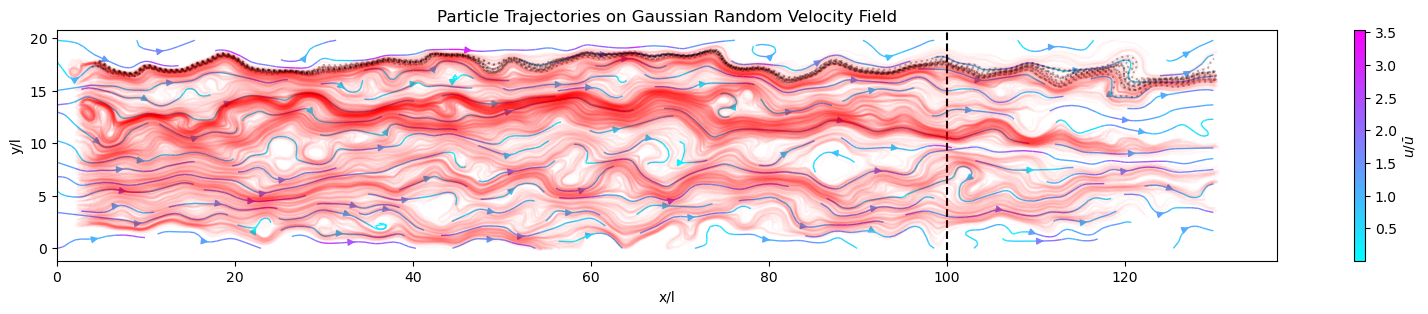

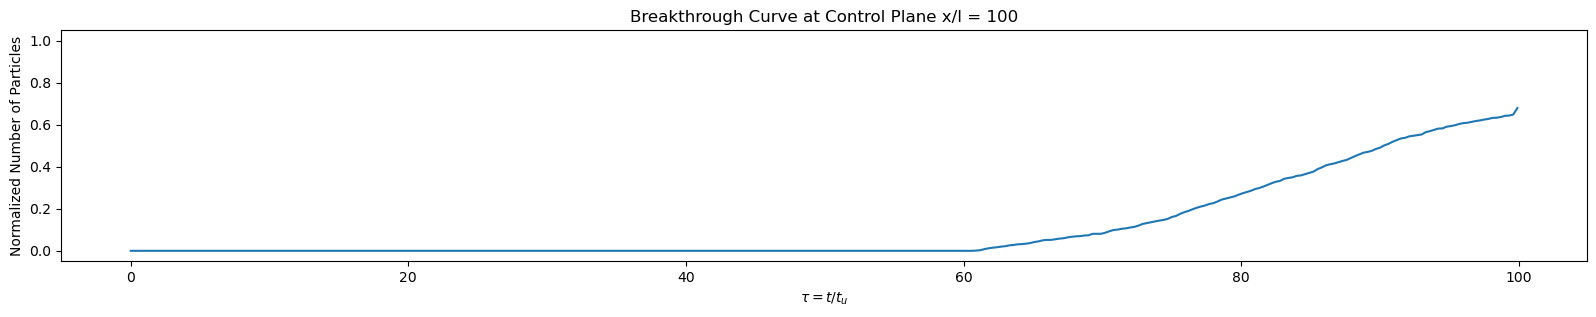

In [4]:
# Plot the velocity field, particle trajectories, and breakthrough curves
simulation.plot_particle_trajectories(vf_idx=0, noise_idx=0, num_first_arrivals=10)

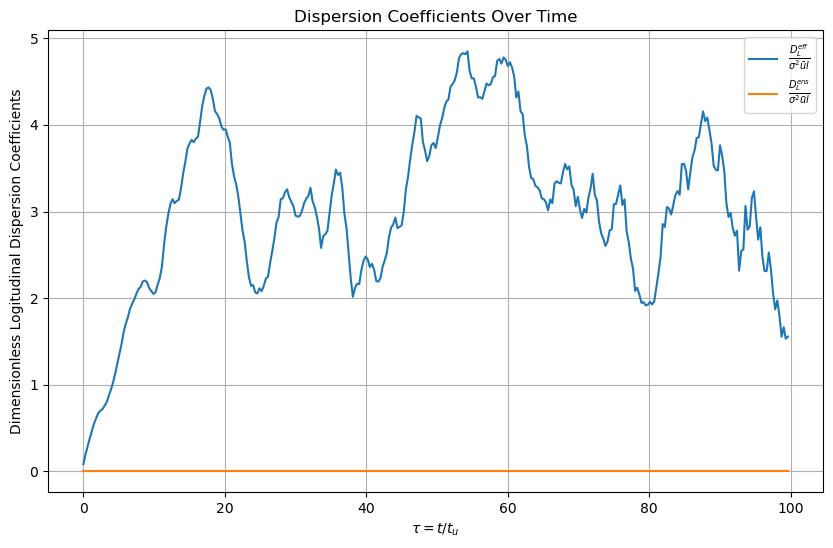

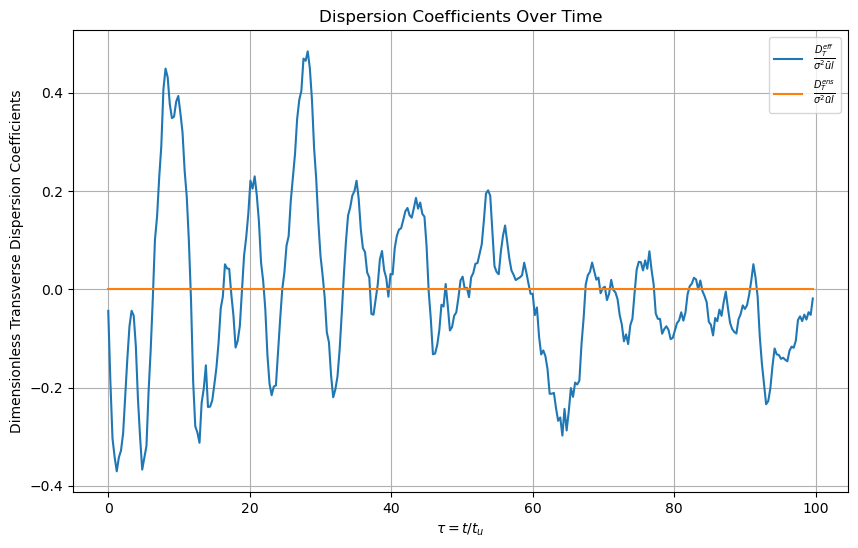

In [5]:
# Calculate and plot the dispersion coefficients
simulation.calculate_dispersion_coefficients()
simulation.plot_dispersion_coefficients()

In [ ]:
# Save the simulation data
np.save('simulation.npy', simulation)